<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Wave_Envelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
import pywt

In [ ]:
#loading the file
file_path = "/content/01-F818D-F8387-220616_0456_8min_selection (1)_female (1).wav"
samples, sampling_rate = librosa.load(file_path,sr=44100)

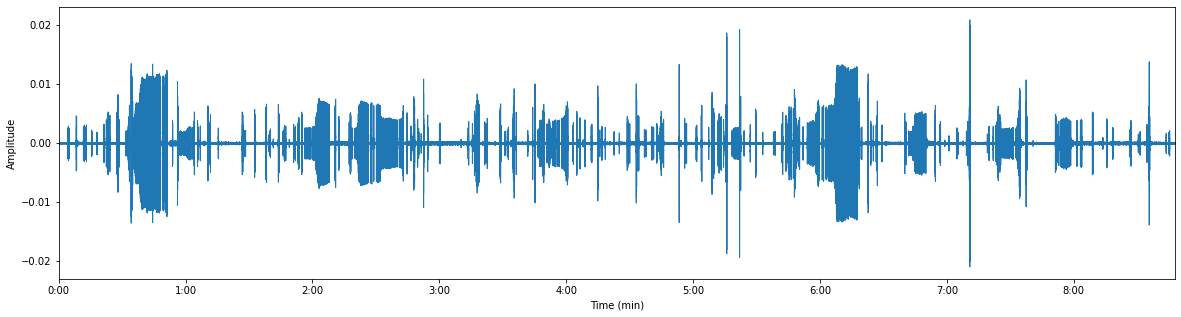

In [ ]:
#plotting the audio data in time domain
plt.figure(figsize=(20,5))
librosa.display.waveplot(y=samples,sr=sampling_rate)
plt.xlabel("Time (min)")
plt.ylabel("Amplitude")
plt.show()

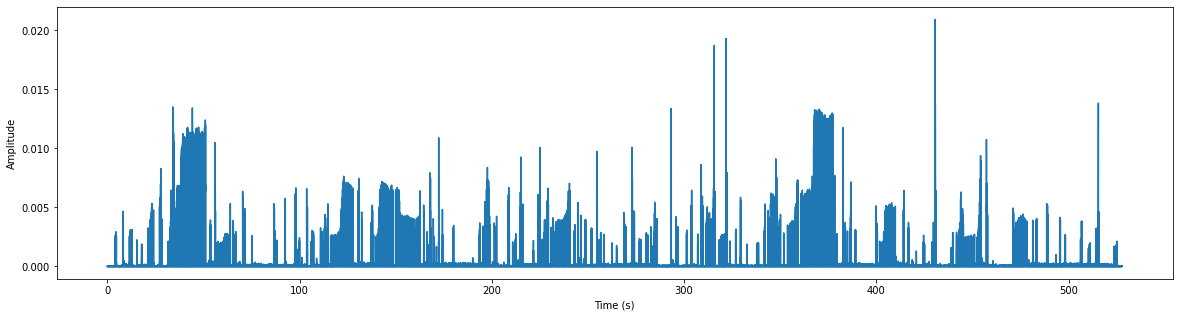

In [ ]:
#getting all sample values into their absolute value
samples_abs = abs(samples)
plt.figure(figsize=(20,5))
duration = len(samples)/sampling_rate
time = np.arange(0,duration,1/sampling_rate) #time vector
plt.plot(time,samples_abs)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# hilbert transfrom envelope on raw data
hilbert_signal = abs(signal.hilbert(samples))

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(time,hilbert_signal,color = "blue")
plt.plot(time,samples_abs+0.01,color = "yellow")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

NameError: ignored

<Figure size 1440x360 with 0 Axes>

In [ ]:
# write("output.wav",sampling_rate,hilbert_signal)

In [ ]:
# generate envelope using continous wavelet transform
coef_list =[]
freq_list=[]
for i in range(94,95):
#i=100
  scale = [1]
  coef, freqs=pywt.cwt(samples,scale,'morl')
  coef_list.append(coef)
  freq_list.append(freqs)

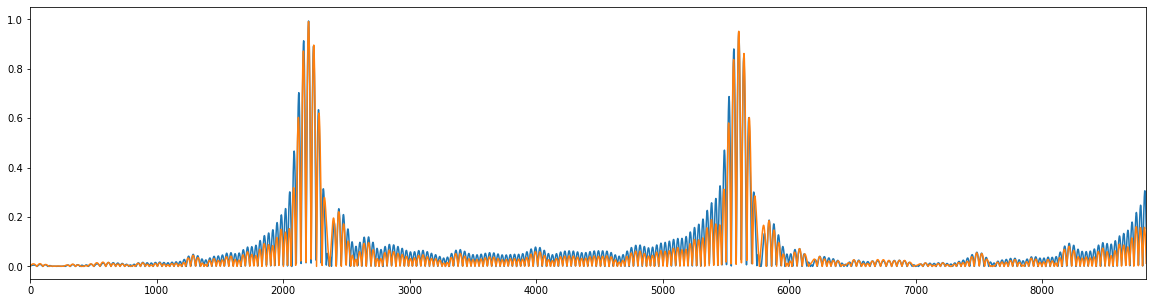

In [ ]:
lbd = int(40*44100)
ubd = int(41*44100)
#first_coef = coef_list[0]
for i in np.arange(0, len(coef_list)):
  plt.figure(figsize=(20,5))
  plt.plot(np.abs(coef_list[i][0][lbd:ubd])/max(np.abs(coef_list[i][0][lbd:ubd])))
  plt.xlim(0,44100*0.2)
  plt.plot(samples_abs[lbd:ubd]/max(samples_abs[lbd:ubd]))
  plt.show()

In [ ]:
# generate envelope using continous wavelet transform
coef_list =[]
freq_list=[]
for i in range(1,9):
  scale = [1]
  coef, freqs=pywt.cwt(samples,scale,'morl')
  coef_list.append(coef)
  freq_list.append(freqs)

In [ ]:
coef, freqs=pywt.cwt(samples,94,'morl')


In [ ]:
a=np.abs(coef.mean(axis=0))
a=a**2
a=a/np.mean(a)
b = a[0::20]

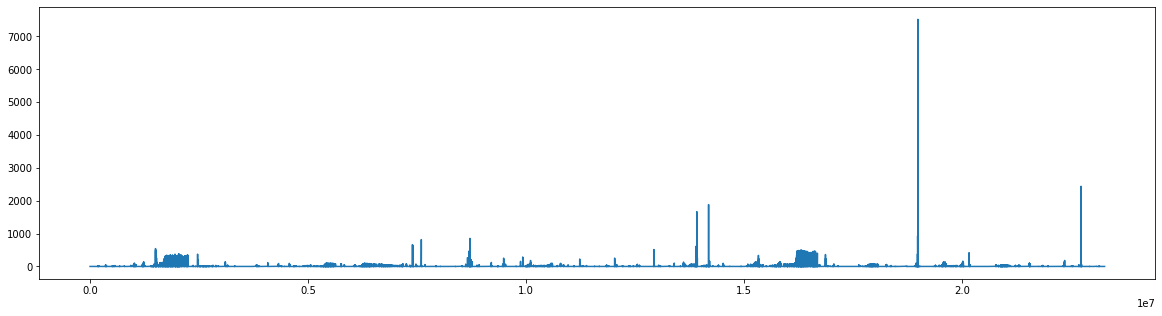

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(a)
#plt.axhline()
#plt.xlim(0,44100*0.2)
#plt.plot(samples_abs[lbd:ubd]/max(samples_abs[lbd:ubd]))
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d
y_smoothed = gaussian_filter1d(a, 1)

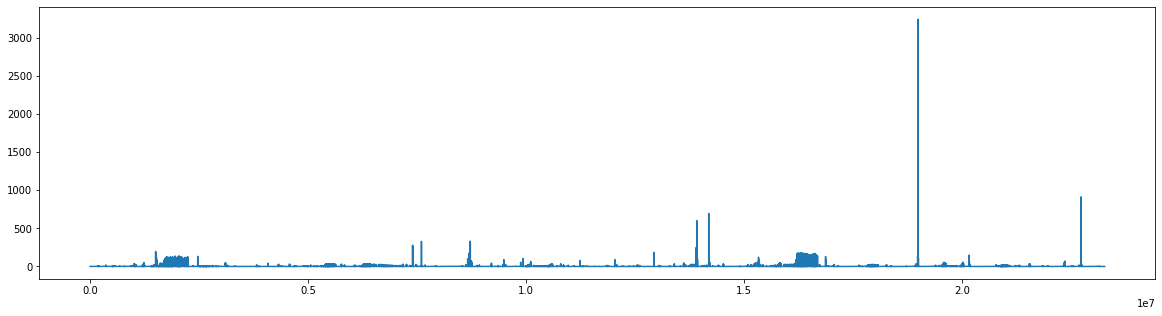

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_smoothed)
plt.show()

In [ ]:
from scipy import signal

peaks,_ = signal.find_peaks(y_smoothed, height = 10)

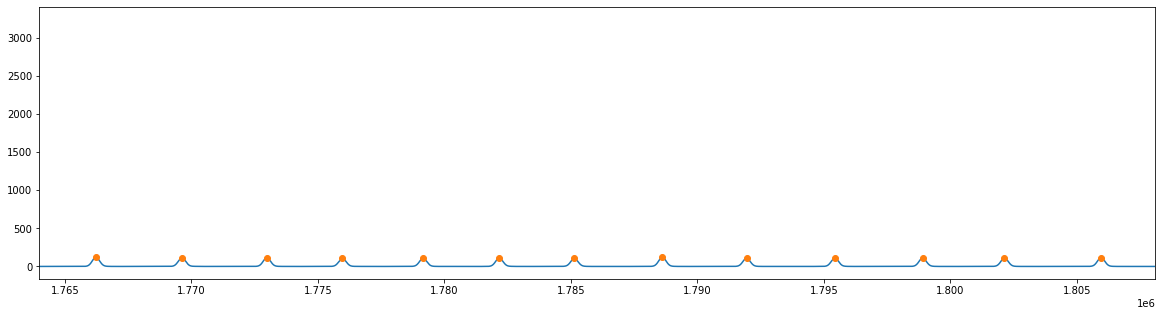

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_smoothed)
plt.plot(peaks, y_smoothed[peaks], 'o')
plt.xlim(40*44100, 41*44100)
plt.show()

In [ ]:
100/44100

0.0022675736961451248